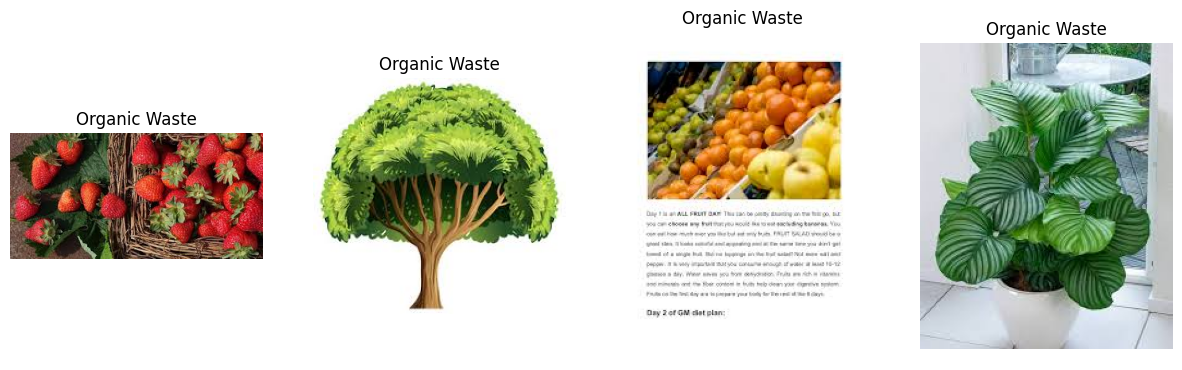

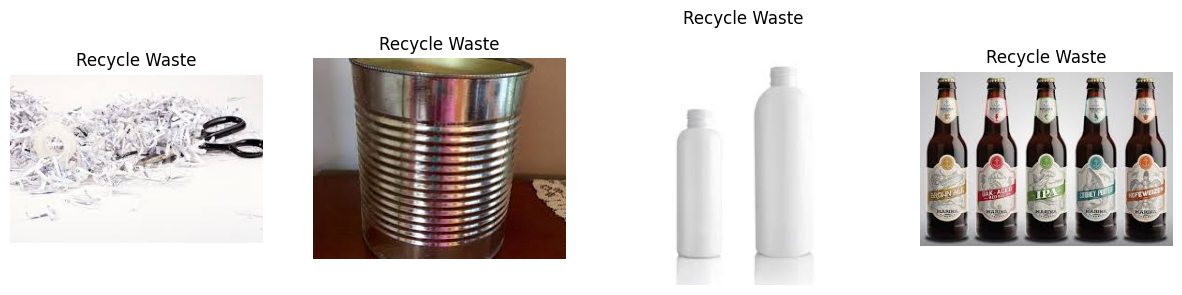

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
import numpy  as np 
import random
from random import seed
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory



# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
def plot_random_images(dataset_dir, category, num_images=4):
    # Path to the specified category directory
    category_dir = os.path.join(dataset_dir, 'TRAIN', category)
    
    # Get the list of image file names in the category directory
    image_files = os.listdir(category_dir)
    
    # Select num_images random images from the category directory
    random_images = random.sample(image_files, num_images)
    
    # Plot the random images
    plt.figure(figsize=(15, 5))
    for i, image_name in enumerate(random_images):
        # Load the image
        image_path = os.path.join(category_dir, image_name)
        image = Image.open(image_path)
        
        # Plot the image
        plt.subplot(1, num_images, i+1)
        plt.imshow(image)
        plt.title(("Organic" if category == 'O' else "Recycle") + " Waste")  # Set the title for each image
        plt.axis('off')
    
    plt.show()
dataset_dir = '/kaggle/input/waste-classification-data/DATASET'
plot_random_images(dataset_dir, 'O', num_images=4)
plot_random_images(dataset_dir, 'R', num_images=4)

In [2]:
from keras.models import Sequential 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import plot_model
from glob import glob
from tqdm import tqdm

import pandas as pd 
import cv2

import warnings
warnings.filterwarnings('ignore')
#libraries used only to load the necessary images not to model anything

2024-05-12 18:20:01.026705: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 18:20:01.026823: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 18:20:01.123572: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train_path = "/kaggle/input/waste-classification-data/DATASET/TRAIN/"
test_path = "/kaggle/input/waste-classification-data/DATASET/TEST/"
x_data = [] 
y_data = [] 

for category in glob(train_path+'/*'):
    for file in tqdm(glob(category+'/*')):
        
        img_array=cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        target_size = (64, 64)

        img_array = cv2.resize(img_array, target_size)
        
        x_data.append(img_array) 
        y_data.append(category.split("/")[-1])

x_data = np.array(x_data)
y_data = np.array(y_data)



100%|██████████| 12565/12565 [01:15<00:00, 166.00it/s]


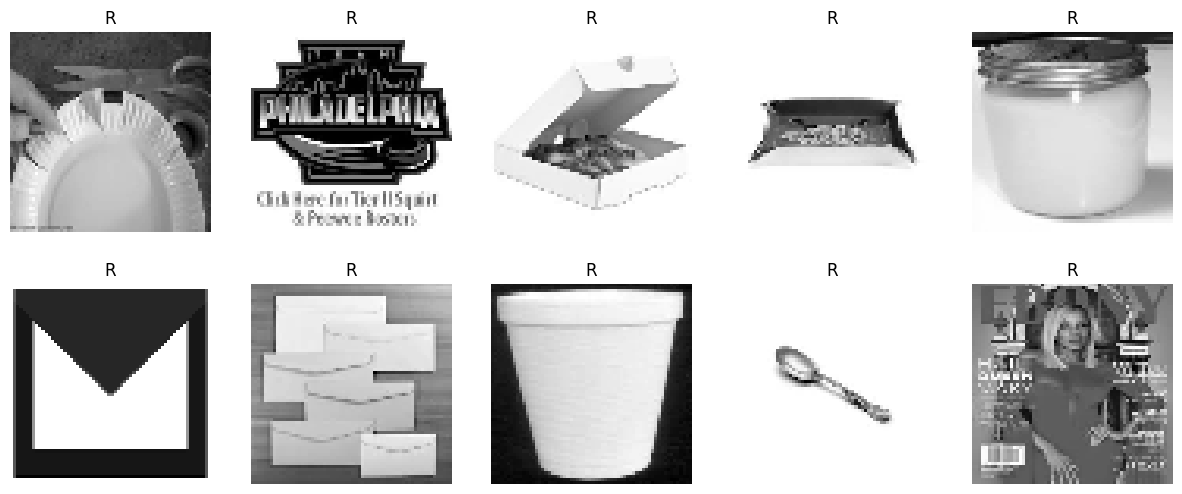

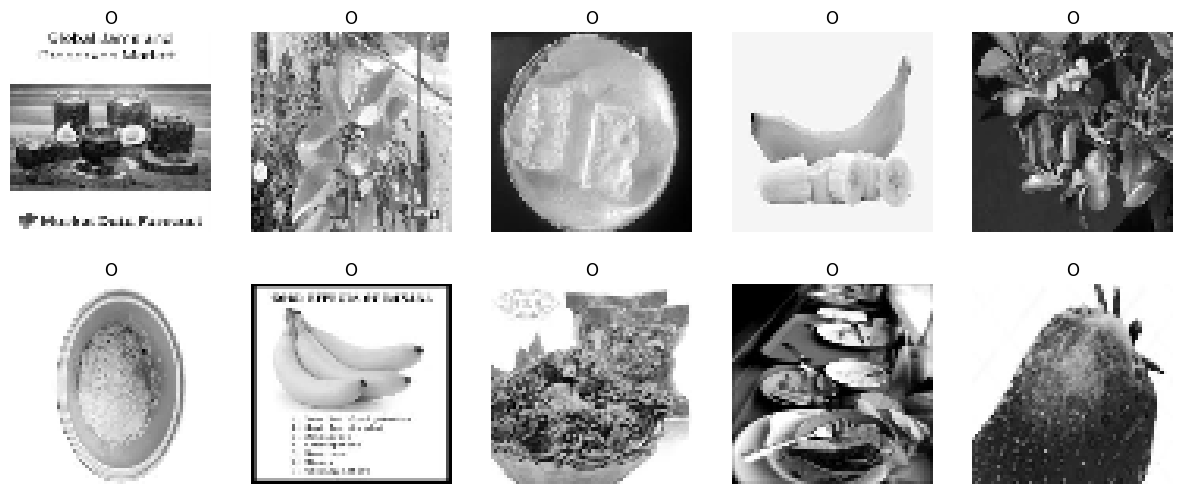

In [4]:
def show_images(images, labels, rows, cols):
    plt.figure(figsize=(cols*3, rows*3))
    for i in range(rows*cols):
        plt.subplot(rows, cols, i+1)
        plt.imshow(images[i], cmap='gray')  # Display grayscale image
        plt.title(labels[i])
        plt.axis('off')
    plt.show()

# Show first 10 images
show_images(x_data[:10], y_data[:10], 2, 5)
show_images(x_data[-10:], y_data[-10:], 2, 5)


In [5]:
x_data_cnn=x_data
x_data = x_data.reshape(x_data.shape[0], -1)

In [6]:
# Converting 'R' to 0 and 'O' to 1

y_data = np.where(y_data == 'R', 0, 1)
y_data_cnn=y_data


In [7]:
y_data

array([0, 0, 0, ..., 1, 1, 1])

In [8]:
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.mean = None

    def fit(self, X):
        # Center the data
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean

        # Compute the covariance matrix
        covariance_matrix = np.cov(X_centered, rowvar=False)

        # Perform eigendecomposition
        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

        # Sort eigenvectors by eigenvalues in descending order
        sorted_indices = np.argsort(eigenvalues)[::-1]
        eigenvectors = eigenvectors[:, sorted_indices]
        eigenvalues = eigenvalues[sorted_indices]

        # Select the top n_components eigenvectors
        self.components = eigenvectors[:, :self.n_components]

    def transform(self, X):
        # Center the data
        X_centered = X - self.mean

        # Project the data onto the principal components
        return np.dot(X_centered, self.components)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

In [9]:
# pca=PCA(10)
# train_images_pca = pca.fit_transform(x_data)

In [10]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        
    def is_leaf_node(self):
        return self.value is not None

class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.root = None
   
    def fit(self, X, y):
       
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # check the stopping criteria
        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, n_feats, replace=False)

        # find the best split
        best_feature, best_thresh = self._best_split(X, y, feat_idxs)

        # create child nodes
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feature, best_thresh, left, right)

    def _best_split(self, X, y, feat_idxs):
        best_gini = float('inf')
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            #thresholds = np.unique(X_column)
            thresholds = (np.sort(np.unique(X_column))[:-1] + np.sort(np.unique(X_column))[1:]) / 2
            for threshold in thresholds:
                
                gini = self._gini_index(y, X_column, threshold)
                if gini < best_gini:
                    best_gini = gini
                    split_idx = feat_idx
                    split_threshold = threshold

        return split_idx, split_threshold

    def _gini_index(self, y, X_column, threshold):
        # print(threshold)
        left_idxs, right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return float('inf')

        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)

        gini_l = 1.0 - sum((np.sum(y[left_idxs] == c) / n_l) ** 2 for c in np.unique(y[left_idxs]))
        gini_r = 1.0 - sum((np.sum(y[right_idxs] == c) / n_r) ** 2 for c in np.unique(y[right_idxs]))

        gini_index = (n_l / n) * gini_l + (n_r / n) * gini_r



        return gini_index

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

In [11]:
from collections import defaultdict
from collections import Counter

clf = DecisionTree(max_depth=4)
clf.fit(train_images_pca, y_data)

In [12]:
test_data_x=[]
test_data_y=[]

for category in glob(test_path+'/*'):
    for file in tqdm(glob(category+'/*')):
        
        img_array=cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        target_size = (64, 64)

        img_array = cv2.resize(img_array, target_size)
        
        test_data_x.append(img_array) 
        test_data_y.append(category.split("/")[-1])

test_data_x = np.array(test_data_x)
test_data_y = np.array(test_data_y)
test_data_x_cnn=test_data_x

test_data_x = test_data_x.reshape(test_data_x.shape[0], -1)
test_data_y = np.where(test_data_y == 'R', 0, 1)
test_data_y_cnn=test_data_y

100%|██████████| 1401/1401 [00:06<00:00, 206.17it/s]


In [13]:
test_data_y

array([0, 0, 0, ..., 1, 1, 1])

In [14]:
test_images_pca = pca.fit_transform(test_data_x)

In [15]:
def classwise_accuracy(y_true, y_pred):
    # Initialize a dictionary to store counts of correct and total predictions for each class
    class_counts = defaultdict(lambda: {'total': 0, 'correct': 0})
    print(np.unique(y_true))
    # Iterate through each pair of true and predicted labels
    for true_label, pred_label in zip(y_true, y_pred):
        # Increment the total count for the true label
        class_counts[true_label]['total'] += 1
        # If the true label matches the predicted label, increment the correct count for that class
        if true_label == pred_label:
            class_counts[true_label]['correct'] += 1

    # Print class-wise accuracy
    for class_label, counts in class_counts.items():
        accuracy = counts['correct'] / counts['total'] if counts['total'] > 0 else 0.0
        print(f"Class {class_label}: Accuracy = {accuracy:.2f} ({counts['correct']} / {counts['total']})")
predictions = clf.predict(test_images_pca)

def accuracy(y_test, y_pred):
    return np.sum(y_test == y_pred) / len(y_test)

acc = accuracy(test_data_y, predictions)
classwise_accuracy(test_data_y,predictions)
print(acc)

In [16]:
def print_tree(node, depth=0):
    if node is None:
        return

    # Indentation based on the depth of the node
    indent = '  ' * depth

    # If the node is a leaf node, print its value
    if node.is_leaf_node():
        print(indent + f"Leaf: {node.value}")
        return

    # Print the decision node
    print(indent + f"Decision: Feature {node.feature} <= {node.threshold}")

    # Recursively print the left and right subtrees
    print_tree(node.left, depth + 1)
    print_tree(node.right, depth + 1)
print_tree(clf.root)

In [17]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.tree import plot_tree
X = [[-960.2164257839427, 689.9569881158321, -102.48321279066967, 2017.1477685289296, -2949.0047311890166, -4259.52236692847, -410.3683391578305, 2040.1795572995893, 1454.644900669773, -1006.2948645297128],
     [-102.48321279066967, 2017.1477685289296, -2949.0047311890166, -4259.52236692847, -410.3683391578305, 2040.1795572995893, 1454.644900669773, -1006.2948645297128, 230.61516420409487, 1923.8962471181337]]

y = [1, 0]

# Create a decision tree classifier
clf = DecisionTreeClassifier()

# Fit the classifier
clf.fit(X, y)

# Plot the decision tree
plt.figure(figsize=(20,10))
plot_tree(clf, filled=True, feature_names=[f'Feature {i}' for i in range(10)], class_names=['0', '1'], rounded=True)
plt.show()

In [18]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Initialize lists to store training accuracies
train_accuracies = []

# Initialize and train the LDA model
lda_model = LinearDiscriminantAnalysis()

lda_model.fit(train_images_pca, y_data)
    
y_pred = lda_model.predict(test_images_pca)
def accuracy(y_test, y_pred):
    return np.sum(y_test == y_pred) / len(y_test)
# Calculate accuracy
accuracy = accuracy(test_data_y, y_pred)
print("Accuracy of LDA model on test data:", accuracy)

In [19]:
def classwise_accuracy(y_true, y_pred):
    # Initialize a dictionary to store counts of correct and total predictions for each class
    class_counts = defaultdict(lambda: {'total': 0, 'correct': 0})
    print(np.unique(y_true))
    # Iterate through each pair of true and predicted labels
    for true_label, pred_label in zip(y_true, y_pred):
        # Increment the total count for the true label
        class_counts[true_label]['total'] += 1
        # If the true label matches the predicted label, increment the correct count for that class
        if true_label == pred_label:
            class_counts[true_label]['correct'] += 1

    # Print class-wise accuracy
    for class_label, counts in class_counts.items():
        accuracy = counts['correct'] / counts['total'] if counts['total'] > 0 else 0.0
        print(f"Class {class_label}: Accuracy = {accuracy:.2f} ({counts['correct']} / {counts['total']})")
classwise_accuracy(test_data_y,y_pred)


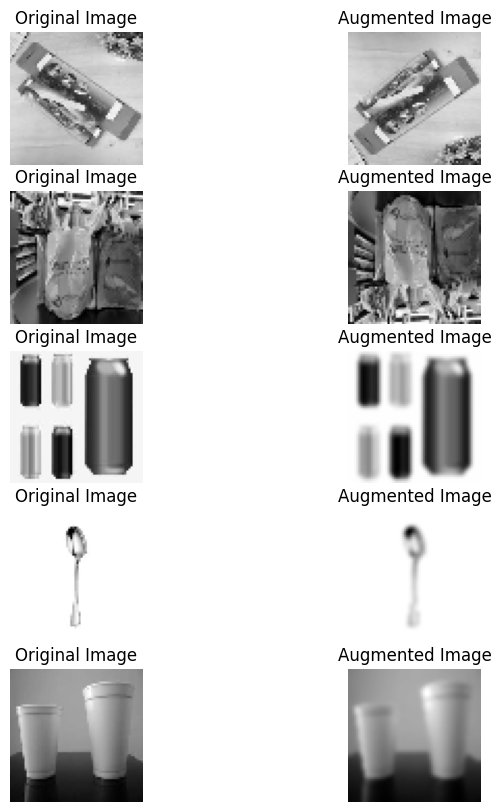

In [41]:

def data_augmentation(images, labels, num_augmented=5000):
    augmented_images = []
    augmented_labels = []

    num_images = len(images)
    indices = np.random.randint(0, num_images, size=num_augmented)
    fig, axes = plt.subplots(5, 2, figsize=(8, 2*5))
    i=0
    for idx in indices:
        image = images[idx]
        label = labels[idx]
        if(i<5):
            axes[i, 0].imshow(image, cmap='gray')  # Display original image
            axes[i, 0].set_title('Original Image')

        
        # Randomly choose an augmentation technique
        augmentation_type = np.random.choice(['flip_horizontal', 'flip_vertical', 'rotate', 'blur'])

        # Apply the chosen augmentation technique
        if augmentation_type == 'flip_horizontal':
            image = cv2.flip(image, 1)  # Flip horizontally
        elif augmentation_type == 'flip_vertical':
            image = cv2.flip(image, 0)  # Flip vertically
        elif augmentation_type == 'rotate':
            if len(image.shape) == 3:  # Color image
                rows, cols, _ = image.shape
            else:  # Grayscale image
                rows, cols = image.shape
            angle = np.random.uniform(-30, 30)  # Random rotation angle between -30 and 30 degrees
            rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
            image = cv2.warpAffine(image, rotation_matrix, (cols, rows))
        elif augmentation_type == 'blur':
            image = cv2.GaussianBlur(image, (5, 5), 0)  # Apply Gaussian blur
        
        if(i<5):
            axes[i, 1].imshow(image, cmap='gray')  # Display augmented image
            axes[i, 1].set_title('Augmented Image')

            axes[i, 0].axis('off')
            axes[i, 1].axis('off')
            i=i+1

        augmented_images.append(image)
        augmented_labels.append(label)

    return np.array(augmented_images), np.array(augmented_labels)


# Example usage
augmented_images, augmented_labels = data_augmentation(x_data_cnn, y_data_cnn, num_augmented=5000)
x_data_cnn = np.concatenate((x_data_cnn, augmented_images), axis=0)
y_data_cnn= np.concatenate((y_data_cnn, augmented_labels), axis=0)


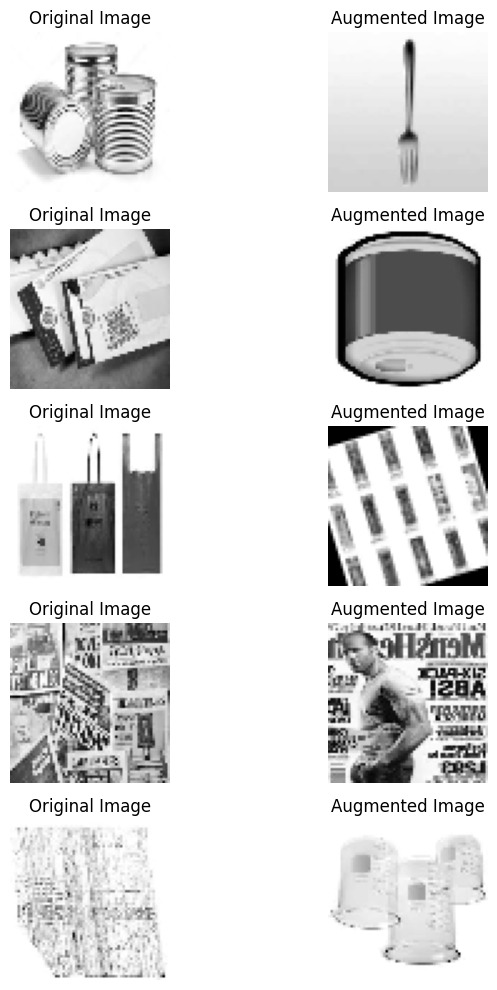

In [42]:
import matplotlib.pyplot as plt

def visualize_augmented_images(original_images, augmented_images, num_samples=5):
    fig, axes = plt.subplots(num_samples, 2, figsize=(8, 2*num_samples))
    for i in range(num_samples):
        idx = np.random.randint(0, len(original_images))

        original_image = original_images[idx].reshape(64, 64)  # Reshape to original dimensions
        augmented_image = augmented_images[idx].reshape(64, 64)  # Reshape to original dimensions

        axes[i, 0].imshow(original_image, cmap='gray')  # Display original image
        axes[i, 0].set_title('Original Image')

        axes[i, 1].imshow(augmented_image, cmap='gray')  # Display augmented image
        axes[i, 1].set_title('Augmented Image')

        axes[i, 0].axis('off')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
visualize_augmented_images(x_data_cnn[:100], augmented_images[:100], num_samples=5)


In [43]:
import numpy as np

class Conv3x3:
    # A Convolution layer using 3x3 filters.
  
    def __init__(self, num_filters):
        self.num_filters = num_filters

        # filters is a 3d array with dimensions (num_filters, 3, 3)
        # We divide by 9 to reduce the variance of our initial values
        self.filters = np.random.randn(num_filters, 3, 3) / 9

    def iterate_regions(self, image):
        '''
        Generates all possible 3x3 image regions using valid padding.
        - image is a 2d numpy array.
        '''
        h, w = image.shape

        for i in range(h - 2):
            for j in range(w - 2):
                im_region = image[i:(i + 3), j:(j + 3)]
                yield im_region, i, j

    def forward(self, input):
        '''
        Performs a forward pass of the conv layer using the given input.
        Returns a 3d numpy array with dimensions (h, w, num_filters).
        - input is a 2d numpy array
        '''
        self.last_input = input

        h, w = input.shape
        output = np.zeros((h - 2, w - 2, self.num_filters))

        for im_region, i, j in self.iterate_regions(input):
            output[i, j] = np.sum(im_region * self.filters, axis=(1, 2))

        return output

    def backprop(self, d_L_d_out, learn_rate):
        '''
        Performs a backward pass of the conv layer.
        - d_L_d_out is the loss gradient for this layer's outputs.
        - learn_rate is a float.
        '''
        d_L_d_filters = np.zeros(self.filters.shape)

        for im_region, i, j in self.iterate_regions(self.last_input):
            for f in range(self.num_filters):
                d_L_d_filters[f] += d_L_d_out[i, j, f] * im_region

        # Update filters
        self.filters -= learn_rate * d_L_d_filters

        # We aren't returning anything here since we use Conv3x3 as the first layer in our CNN.
        # Otherwise, we'd need to return the loss gradient for this layer's inputs, just like every
        # other layer in our CNN.
        return None


In [44]:
import numpy as np

class MaxPool2:
    # A Max Pooling layer using a pool size of 2.

    def iterate_regions(self, image):
        '''
        Generates non-overlapping 2x2 image regions to pool over.
        - image is a 3d numpy array
        '''
        h, w, _ = image.shape
        new_h = h // 2
        new_w = w // 2

        for i in range(new_h):
            for j in range(new_w):
                im_region = image[(i * 2):(i * 2 + 2), (j * 2):(j * 2 + 2)]
                yield im_region, i, j

    def forward(self, input):
        '''
        Performs a forward pass of the maxpool layer using the given input.
        Returns a 3d numpy array with dimensions (h / 2, w / 2, num_filters).
        - input is a 3d numpy array with dimensions (h, w, num_filters)
        '''
        self.last_input = input

        h, w, num_filters = input.shape
        output = np.zeros((h // 2, w // 2, num_filters))

        for im_region, i, j in self.iterate_regions(input):
            output[i, j] = np.amax(im_region, axis=(0, 1))

        return output

    def backprop(self, d_L_d_out):
        '''
        Performs a backward pass of the maxpool layer.
        Returns the loss gradient for this layer's inputs.
        - d_L_d_out is the loss gradient for this layer's outputs.
        '''
        d_L_d_input = np.zeros(self.last_input.shape)

        for im_region, i, j in self.iterate_regions(self.last_input):
            h, w, f = im_region.shape
            amax = np.amax(im_region, axis=(0, 1))

            for i2 in range(h):
                for j2 in range(w):
                    for f2 in range(f):
                        # If this pixel was the max value, copy the gradient to it.
                        if im_region[i2, j2, f2] == amax[f2]:
                            d_L_d_input[i * 2 + i2, j * 2 + j2, f2] = d_L_d_out[i, j, f2]

        return d_L_d_input


In [45]:
import numpy as np

class Softmax:
    # A standard fully-connected layer with softmax activation.

    def __init__(self, input_len, nodes):
        # We divide by input_len to reduce the variance of our initial values
        self.weights = np.random.randn(input_len, nodes) / input_len
        self.biases = np.zeros(nodes)

    def forward(self, input):
        '''
        Performs a forward pass of the softmax layer using the given input.
        Returns a 1d numpy array containing the respective probability values.
        - input can be any array with any dimensions.
        '''
        self.last_input_shape = input.shape

        input = input.flatten()
        self.last_input = input

        input_len, nodes = self.weights.shape
#         print("input size ",input.shape)
#         print("weights size ",self.weights.shape)

        totals = np.dot(input, self.weights) + self.biases
        self.last_totals = totals

        exp = np.exp(totals)
        return exp / np.sum(exp, axis=0)

    def backprop(self, d_L_d_out, learn_rate):
        '''
        Performs a backward pass of the softmax layer.
        Returns the loss gradient for this layer's inputs.
        - d_L_d_out is the loss gradient for this layer's outputs.
        - learn_rate is a float.
        '''
        # We know only 1 element of d_L_d_out will be nonzero
        for i, gradient in enumerate(d_L_d_out):
            if gradient == 0:
                continue

            # e^totals
            t_exp = np.exp(self.last_totals)

            # Sum of all e^totals
            S = np.sum(t_exp)

            # Gradients of out[i] against totals
            d_out_d_t = -t_exp[i] * t_exp / (S ** 2)
            d_out_d_t[i] = t_exp[i] * (S - t_exp[i]) / (S ** 2)

            # Gradients of totals against weights/biases/input
            d_t_d_w = self.last_input
            d_t_d_b = 1
            d_t_d_inputs = self.weights

            # Gradients of loss against totals
            d_L_d_t = gradient * d_out_d_t

            # Gradients of loss against weights/biases/input
            d_L_d_w = d_t_d_w[np.newaxis].T @ d_L_d_t[np.newaxis]
            d_L_d_b = d_L_d_t * d_t_d_b
            d_L_d_inputs = d_t_d_inputs @ d_L_d_t

            # Update weights / biases
            self.weights -= learn_rate * d_L_d_w
            self.biases -= learn_rate * d_L_d_b

            return d_L_d_inputs.reshape(self.last_input_shape)


In [46]:
conv = Conv3x3(8)                  # 28x28x1 -> 26x26x8
pool = MaxPool2()                  # 26x26x8 -> 13x13x8
softmax = Softmax(31 * 31 * 8, 2) # 32x32x8 -> 10

def forward(image, label):
    '''
    Completes a forward pass of the CNN and calculates the accuracy and
    cross-entropy loss.
    - image is a 2d numpy array
    - label is a digit
    '''
    # We transform the image from [0, 255] to [-0.5, 0.5] to make it easier
    # to work with. This is standard practice.
    out = conv.forward((image / 255) - 0.5)
#     print("conv : ",out.shape)
    out = pool.forward(out)
    out = softmax.forward(out)

    # Calculate cross-entropy loss and accuracy. np.log() is the natural log.
    loss = -np.log(out[label])
    acc = 1 if np.argmax(out) == label else 0

    return out, loss, acc

def train(im, label, lr=.005):
    '''
    Completes a full training step on the given image and label.
    Returns the cross-entropy loss and accuracy.
    - image is a 2d numpy array
    - label is a digit
    - lr is the learning rate
    '''
    # Forward
    out, loss, acc = forward(im, label)

    # Calculate initial gradient
    gradient = np.zeros(10)
    gradient[label] = -1 / out[label]

    # Backprop
    gradient = softmax.backprop(gradient, lr)
    gradient = pool.backprop(gradient)
    gradient = conv.backprop(gradient, lr)

    return loss, acc


In [47]:
print(x_data_cnn.shape)
print(y_data_cnn.shape)

(9000, 64, 64)
(9000,)


In [ ]:
import tensorflow as tf

# Check if GPU is available and its name
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("GPU device not found")


for epoch in range(1):
    print('--- Epoch %d ---' % (epoch + 1))

    # Shuffle the training data
    permutation = np.random.permutation(len(x_data_cnn))
    train_images = x_data_cnn[permutation]
    train_labels = y_data_cnn[permutation]

    # Train!
    loss = 0
    num_correct = 0
    for i, (im, label) in enumerate(zip(train_images, train_labels)):
        if i % 100 == 99:
            print(
                '[Step %d] Past 100 steps: Average Loss %.3f | Accuracy: %d%%' %
                (i + 1, loss / 100, num_correct)
            )
            loss = 0
            num_correct = 0

        l, acc = train(im, label)
        loss += l
        num_correct += acc

# Test the CNN
print('\n--- Testing the CNN ---')
loss = 0
num_correct = 0
for im, label in zip(test_data_x_cnn, test_data_y_cnn):
    _, l, acc = forward(im, label)
    loss += l
    num_correct += acc

num_tests = len(test_data_x_cnn)
print('Test Loss:', loss / num_tests)
print('Test Accuracy:', num_correct / num_tests)


Default GPU Device: /device:GPU:0
--- Epoch 1 ---
[Step 100] Past 100 steps: Average Loss 0.279 | Accuracy: 90%
[Step 200] Past 100 steps: Average Loss 0.150 | Accuracy: 95%
[Step 300] Past 100 steps: Average Loss 0.133 | Accuracy: 95%
[Step 400] Past 100 steps: Average Loss 0.115 | Accuracy: 97%
[Step 500] Past 100 steps: Average Loss 0.060 | Accuracy: 99%
[Step 600] Past 100 steps: Average Loss 0.035 | Accuracy: 100%
[Step 700] Past 100 steps: Average Loss 0.065 | Accuracy: 99%
[Step 800] Past 100 steps: Average Loss 0.044 | Accuracy: 98%
[Step 900] Past 100 steps: Average Loss 0.029 | Accuracy: 100%
[Step 1000] Past 100 steps: Average Loss 0.061 | Accuracy: 99%
[Step 1100] Past 100 steps: Average Loss 0.029 | Accuracy: 100%
[Step 1200] Past 100 steps: Average Loss 0.064 | Accuracy: 98%
[Step 1300] Past 100 steps: Average Loss 0.027 | Accuracy: 99%
[Step 1400] Past 100 steps: Average Loss 0.029 | Accuracy: 100%
[Step 1500] Past 100 steps: Average Loss 0.034 | Accuracy: 99%
[Step 1600